## Trivariate Analysis: Enrollment-to-Biometric Drop-offs

This notebook analyses Aadhaar enrollment-to-biometric conversion across
States and Age Groups to identify structural drop-offs in registration.


In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mplcursors
import matplotlib.cm as cm

In [ ]:
files_enrollment = ["data/1api_data_aadhar_enrolment/api_data_aadhar_enrolment_0_500000.csv",
                   "data/1api_data_aadhar_enrolment/api_data_aadhar_enrolment_500000_1000000.csv",
                   "data/1api_data_aadhar_enrolment/api_data_aadhar_enrolment_1000000_1006029.csv"]

files_demographic = ["data/2api_data_aadhar_demographic/api_data_aadhar_demographic_0_500000.csv",
                     "data/2api_data_aadhar_demographic/api_data_aadhar_demographic_500000_1000000.csv",
                     "data/2api_data_aadhar_demographic/api_data_aadhar_demographic_1000000_1500000.csv",
                     "data/2api_data_aadhar_demographic/api_data_aadhar_demographic_1500000_2000000.csv",
                     "data/2api_data_aadhar_demographic/api_data_aadhar_demographic_2000000_2071700.csv"]

files_biometric = ["data/3api_data_aadhar_biometric/api_data_aadhar_biometric_0_500000.csv",
                   "data/3api_data_aadhar_biometric/api_data_aadhar_biometric_500000_1000000.csv",
                   "data/3api_data_aadhar_biometric/api_data_aadhar_biometric_1000000_1500000.csv",
                   "data/3api_data_aadhar_biometric/api_data_aadhar_biometric_1500000_1861108.csv"]

df1 = pd.concat([pd.read_csv(f) for f in files_enrollment], ignore_index=True) # type: ignore
df2 = pd.concat([pd.read_csv(f) for f in files_demographic], ignore_index=True)
df3 = pd.concat([pd.read_csv(f) for f in files_biometric], ignore_index=True)

print("Total enrollment records:", len(df1))
print("Total demographic records:", len(df2))
print("Total biometric records:", len(df3))

Total enrollment records: 1006029
Total demographic records: 2071700
Total biometric records: 1861108


In [70]:
df1["state_clean"]=df1['state'].str.lower().str.strip()

df2["state_clean"]=df2['state'].str.lower().str.strip()

df3["state_clean"]=df3['state'].str.lower().str.strip()

In [71]:
fix_map = {
    "andaman & nicobar": "andaman and nicobar islands",
    "andaman and nicobar": "andaman and nicobar islands",
    "andaman & nicobar islands": "andaman and nicobar islands",
    
    "chhatisgarh": "chhattisgarh",
    
    "orissa": "odisha",
    
    "pondicherry": "puducherry",
    
    "tamilnadu": "tamil nadu",
    
    "west bangal": "west bengal",
    "westbengal": "west bengal",
    "west  bengal": "west bengal",
    "west bengli": "west bengal",
    
    "jammu & kashmir": "jammu and kashmir",
    
    "dadra & nagar haveli": "dadra and nagar haveli and  daman and diu",
    "dadra and nagar haveli": "dadra and nagar haveli and  daman and diu",
    "daman and diu": "dadra and nagar haveli and  daman and diu",
    "daman & diu": "dadra and nagar haveli and  daman and diu",
    "dadra and nagar haveli and  daman and diu": "dadra and nagar haveli and  daman and diu",
    "dadra and nagar haveli and daman and diu": "dadra and nagar haveli and  daman and diu",
    "the dadra and nagar haveli and daman and diu": "dadra and nagar haveli and  daman and diu",
    
    "uttaranchal": "uttarakhand",
    "darbhanga": "bihar",
    "balanagar": "telangana",
    "jaipur": "rajasthan",
    "madanapalle": "andhra pradesh",
    "puttenahalli": "karnataka",
    "nagpur": "maharashtra",
    "raja annamalai puram": "tamil nadu",
    
    "100000" : None
    }

In [ ]:
df1["state_clean"] = df1["state_clean"].replace(fix_map)
df1 = df1[df1["state_clean"].notna()]

df2["state_clean"] = df2["state_clean"].replace(fix_map)
df2 = df2[df2["state_clean"].notna()]

df3["state_clean"] = df3["state_clean"].replace(fix_map)
df3 = df3[df3["state_clean"].notna()]

In [73]:
df1.columns, df2.columns, df3.columns


(Index(['date', 'state', 'district', 'pincode', 'age_0_5', 'age_5_17',
        'age_18_greater', 'state_clean'],
       dtype='object'),
 Index(['date', 'state', 'district', 'pincode', 'demo_age_5_17', 'demo_age_17_',
        'state_clean'],
       dtype='object'),
 Index(['date', 'state', 'district', 'pincode', 'bio_age_5_17', 'bio_age_17_',
        'state_clean'],
       dtype='object'))

In [74]:
# Aggregate ENROLLMENT by state
enroll_state = (
    df1
    .groupby("state_clean", as_index=False)
    .agg({
        "age_5_17": "sum",
        "age_18_greater": "sum"
    })
)


In [75]:
# Aggregate DEMOGRAPHIC by state
demo_state = (
    df2
    .groupby("state_clean", as_index=False)
    .agg({
        "demo_age_5_17": "sum",
        "demo_age_17_": "sum"
    })
)

In [76]:
# Aggregate BIOMETRIC by state
bio_state = (
    df3
    .groupby("state_clean", as_index=False)
    .agg({
        "bio_age_5_17": "sum",
        "bio_age_17_": "sum"
    })
)


In [77]:
# Merge (STATE LEVEL DATASET)
merged = enroll_state.merge(
    bio_state,
    on="state_clean",
    how="inner"
)


In [ ]:
# Calculate DROP-OFF (AGE-WISE)

merged["drop_5_17"] = (
    (merged["age_5_17"] - merged["bio_age_5_17"])
    / merged["age_5_17"])

merged["drop_18_plus"] = (
    (merged["age_18_greater"] - merged["bio_age_17_"])
    / merged["age_18_greater"])

In [79]:
# Handle invalid values (CRITICAL)
merged = merged.replace([np.inf, -np.inf], np.nan)

merged = merged.dropna(subset=["drop_5_17", "drop_18_plus"])

In [80]:
# Convert to LONG format (for trivariate plot)
dropoff_long = merged.melt(
    id_vars="state_clean",
    value_vars=["drop_5_17", "drop_18_plus"],
    var_name="age_group",
    value_name="dropoff_rate"
)


In [81]:
# Clean age labels
dropoff_long["age_group"] = dropoff_long["age_group"].map({
    "drop_5_17": "Age 5–17",
    "drop_18_plus": "Age 18+"
})

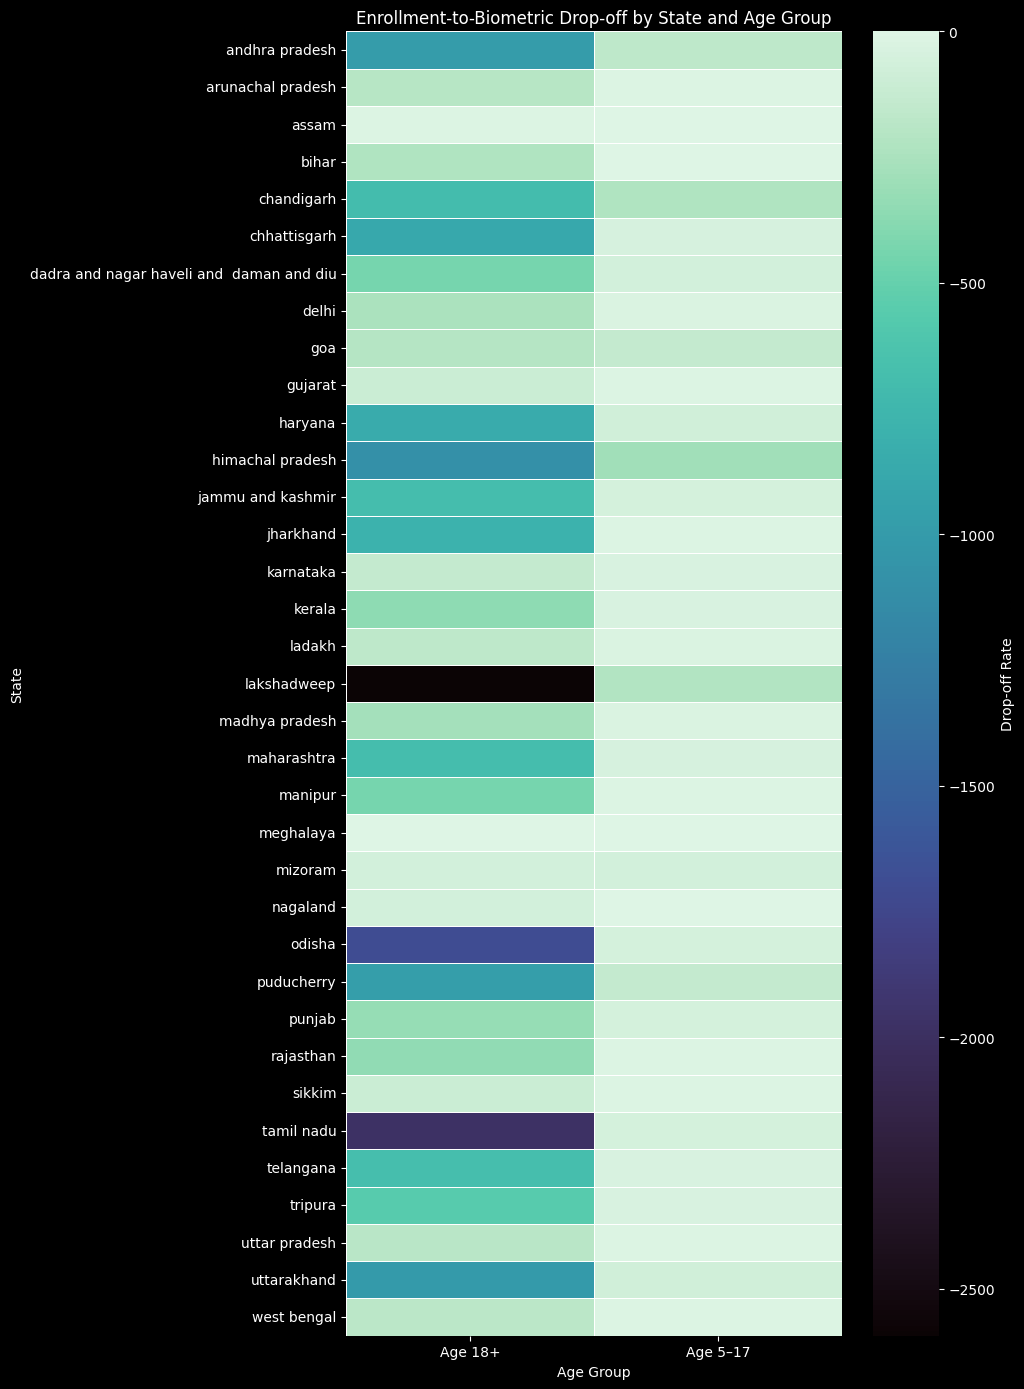

In [ ]:
# TRIVARIATE HEATMAP (FINAL)
# type: ignore

pivot = dropoff_long.pivot_table(
    index="state_clean",
    columns="age_group",
    values="dropoff_rate"
)

plt.figure(figsize=(10, 14))
sns.heatmap(
    pivot,
    cmap="mako",
    linewidths=0.4,
    cbar_kws={"label": "Drop-off Rate"}
)

plt.title("Enrollment-to-Biometric Drop-off by State and Age Group")
plt.xlabel("Age Group")
plt.ylabel("State")
plt.tight_layout()
plt.show()

C:\Users\Riyaa.000\AppData\Local\Temp\ipykernel_11976\3856579901.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab20", num_states)


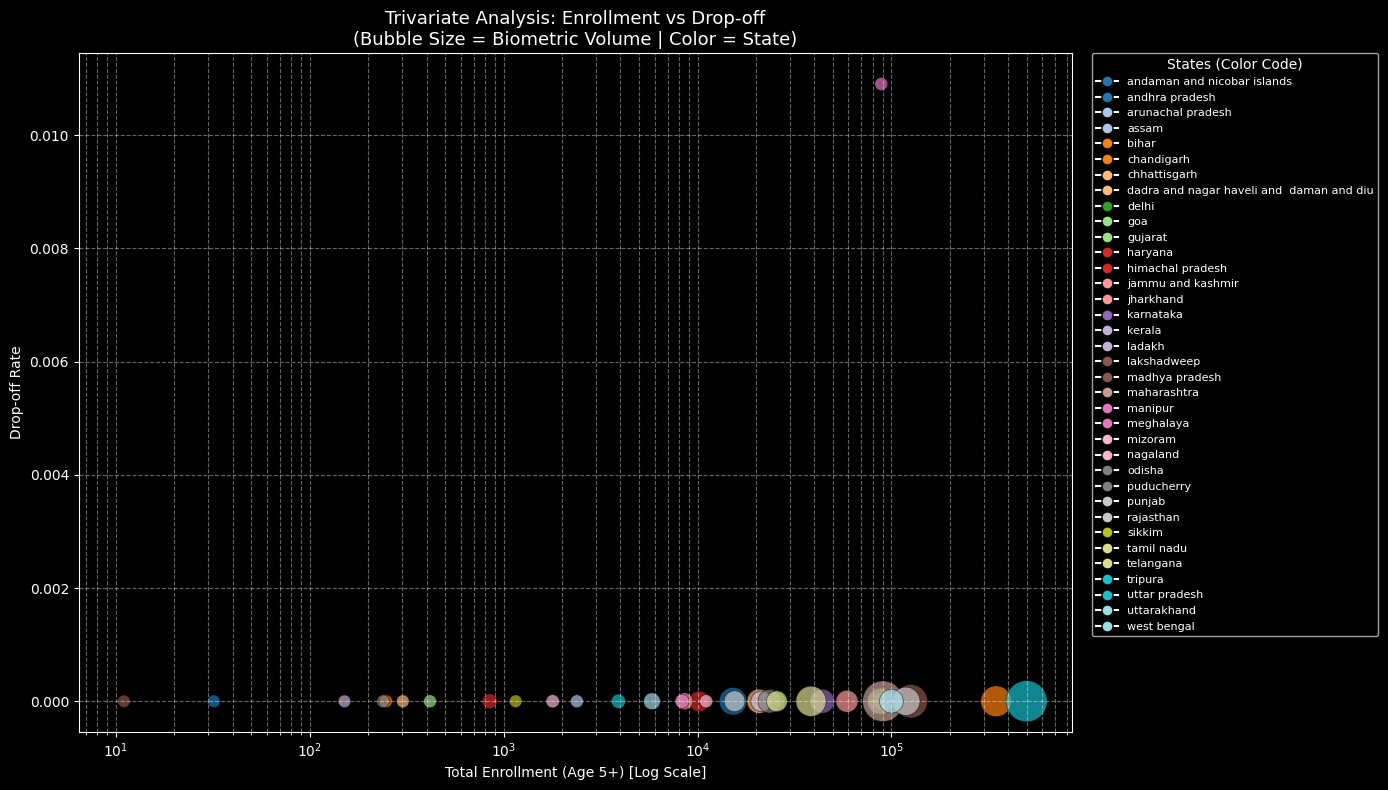

In [83]:
# TRIVARIATE BUBBLE CHART (FINAL)

# Aggregate ENROLLMENT (Age 5+)
enroll_state = (
    df1.groupby("state_clean", as_index=False)[["age_5_17", "age_18_greater"]]
       .sum()
)
enroll_state["enrollment_5_plus"] = (
    enroll_state["age_5_17"] + enroll_state["age_18_greater"]
)

# Aggregate BIOMETRIC (Age 5+)
bio_state = (
    df3.groupby("state_clean", as_index=False)[["bio_age_5_17", "bio_age_17_"]]
       .sum()
)
bio_state["biometric_5_plus"] = (
    bio_state["bio_age_5_17"] + bio_state["bio_age_17_"]
)

# Merge
merged = enroll_state.merge(
    bio_state[["state_clean", "biometric_5_plus"]],
    on="state_clean",
    how="inner"
)

merged["dropoff_rate"] = (
    (merged["enrollment_5_plus"] - merged["biometric_5_plus"])
    / merged["enrollment_5_plus"]
).clip(0, 1)

# BUBBLE CHART

states = merged["state_clean"].unique()
num_states = len(states)

cmap = cm.get_cmap("tab20", num_states)
color_map = {state: cmap(i) for i, state in enumerate(states)}

colors = merged["state_clean"].map(color_map)

plt.figure(figsize=(14, 8))

plt.scatter(
    merged["enrollment_5_plus"],
    merged["dropoff_rate"],
    s=(merged["biometric_5_plus"] / merged["biometric_5_plus"].max()) * 800 + 80,
    c=colors,
    alpha=0.7,
    edgecolors="black",
    linewidths=0.4
)

plt.xscale("log")

plt.xlabel("Total Enrollment (Age 5+) [Log Scale]")
plt.ylabel("Drop-off Rate")
plt.title(
    "Trivariate Analysis: Enrollment vs Drop-off\n"
    "(Bubble Size = Biometric Volume | Color = State)",
    fontsize=13
)

plt.grid(True, which="both", linestyle="--", alpha=0.4)

handles = [
    plt.Line2D(
        [0], [0],
        marker="o",
        color="w",
        label=state,
        markerfacecolor=color_map[state],
        markersize=8,
        markeredgecolor="black"
    )
    for state in states
]

plt.legend(
    handles=handles,
    title="States (Color Code)",
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    borderaxespad=0,
    fontsize=8
)

plt.tight_layout()
plt.show()


### Trivariate Insights

- Biometric drop-off rates are consistently higher in the 5–17 age group compared to adults.
- Adult (18+) enrollment shows stronger completion across most states.
- Certain states exhibit elevated drop-offs across age groups, indicating systemic enrollment-to-biometric gaps.
